In this notebook, we will explore word embeddings based on the news articles in the Brown Corpus. Note that the content is heavily borrowed from the official tensorflow tutorial: https://www.tensorflow.org/tutorials/word2vec

In [1]:
import numpy as np
import tensorflow as tf
%pylab inline
pylab.style.use('ggplot')
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# What are Word Embeddings?

Vector space models (VSMs) represent (embed) words in a continuous vector space where semantically similar words are mapped to nearby points ('are embedded nearby each other'). VSMs have a long, rich history in NLP, but all methods depend in some way or another on the Distributional Hypothesis, which states that words that appear in the same contexts share semantic meaning. 

Predictive models directly try to predict a word from its neighbors in terms of learned small, dense embedding vectors (considered parameters of the model).

Word2vec is a particularly computationally-efficient predictive model for learning word embeddings from raw text. It comes in two flavors, the Continuous Bag-of-Words model (CBOW) and the Skip-Gram model. 

Algorithmically, these models are similar, except that CBOW predicts target words (e.g. 'mat') from source context words ('the cat sits on the'), while the skip-gram does the inverse and predicts source context-words from the target words. This inversion might seem like an arbitrary choice, but statistically it has the effect that CBOW smoothes over a lot of the distributional information (by treating an entire context as one observation). For the most part, this turns out to be a useful thing for smaller datasets. However, skip-gram treats each context-target pair as a new observation, and this tends to do better when we have larger datasets. 

# Noise-Contrastive Training

Neural probabilistic language models are traditionally trained using the maximum likelihood (ML) principle to maximize the probability of the next word (for "target") given the previous words (for "history") in terms of a softmax function.

$$\begin{align}
P(w_t | h) &= \text{softmax} (\text{score} (w_t, h)) \\
           &= \frac{\exp \{ \text{score} (w_t, h) \} }
             {\sum_\text{Word w' in Vocab} \exp \{ \text{score} (w', h) \} }
\end{align}$$


This yields a properly normalized probabilistic model for language modeling. However this is very expensive, because we need to compute and normalize each probability using the score for all other words in the current context , at every training step.

<img src="https://www.tensorflow.org/images/softmax-nplm.png" width="400", height="400" />

On the other hand, for feature learning in word2vec we do not need a full probabilistic model. The CBOW and skip-gram models are instead trained using a binary classification objective (logistic regression) to discriminate the real target words from imaginary (noise) words , in the same context. We illustrate this below for a CBOW model. For skip-gram the direction is simply inverted.

<img src="https://www.tensorflow.org/images/nce-nplm.png" width="400", height="400" />

Mathematically, the loss function is:

$$J_\text{NEG} = \log Q_\theta(D=1 |w_t, h) +  k \mathop{\mathbb{E}}_{\tilde w \sim P_\text{noise}} \left[ \log Q_\theta(D = 0 |\tilde w, h) \right]$$
    
     
Where $Q_{\theta}(D=1 | w, h)$ is the binary logistic regression probability under the model of seeing the word in the context in the dataset , calculated in terms of the learned embedding vectors . In practice we approximate the expectation by drawing contrastive words from the noise distribution (i.e. we compute a Monte Carlo average).

This objective is maximized when the model assigns high probabilities to the real words, and low probabilities to noise words. Technically, this is called Negative Sampling, and there is good mathematical motivation for using this loss function: The updates it proposes approximate the updates of the softmax function in the limit. But computationally it is especially appealing because computing the loss function now scales only with the number of noise words that we select, and not all words in the vocabulary. This makes it much faster to train. We will actually make use of the very similar noise-contrastive estimation (NCE) loss, for which TensorFlow has a handy helper function `tf.nn.nce_loss()`.

# Getting the Data

In [2]:
import nltk
nltk.download('brown')
from nltk.corpus import brown

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


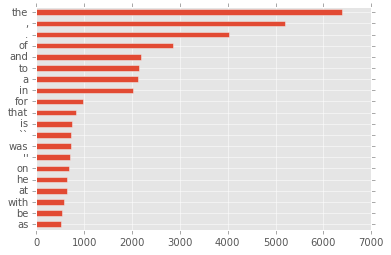

In [3]:
brown_words =  brown.words(categories=['news'])
lcase_words = [w.lower() for w in brown_words]

word_counts = pd.Series(lcase_words).value_counts()
word_counts.nlargest(20).sort_values().plot(kind='barh')

In [4]:
word_counts.count()

13112

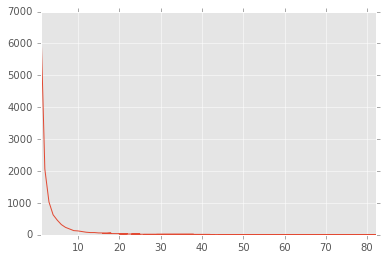

In [5]:
word_counts.value_counts().sort_values(ascending=False).plot()

so, the majority of the words are rare. There are only a small number of words that appear < 10 times.

In [6]:
word_counts[word_counts > 5].count()

2099

# Preprocessing

In the preprocessing step, we will convert all the words to lowercase and pack the sentences into a `pandas.Series`.

In [7]:
lcase_sents = []

for s in brown.sents(categories=['news']):
    lcase_sents.append([w.lower() for w in s])
    
lcase_sents = pd.Series(data=lcase_sents, name='sentences')

In [8]:
lcase_sents.head()

0    [the, fulton, county, grand, jury, said, frida...
1    [the, jury, further, said, in, term-end, prese...
2    [the, september-october, term, jury, had, been...
3    [``, only, a, relative, handful, of, such, rep...
4    [the, jury, said, it, did, find, that, many, o...
Name: sentences, dtype: object

The next step is to generate the (context, target) pairs from a given sentence for a given window size and skip size. 

In [9]:
def gen_context_target_pairs(sent, w_size=1, n_skip=1):
    """
    Convert each sentence (a list of words) to a DataFrame with two columns, 'context' and 'target' for the 
    skip-gram model. The DataFrame has one row for each possible target.
    
    Target is always a single word. For a given target, we build the context by taking the 
    `w_size` sized window centered on target and skipping `n_skip` words.
        
    Assumes each sentence has > w_size words.
    """
    w_length = 2 * w_size + 1
    # our context must have at least 1 word
    assert n_skip < w_length - 1
    
    # sent must have enough words
    assert len(sent) > w_length, sent
    
    recs = []
    for i, w in enumerate(sent):
        if i < w_size or i + w_size + 1 > len(sent):
        # in this case, we don't have a full window
            continue
        else:
            full_context = sent[i-w_size:i] + sent[i+1:i+w_size+1]
            skip_context = random.choice(full_context, len(full_context) - n_skip)
            recs.append([skip_context, w])
            
    rec_df = pd.DataFrame.from_records(recs, columns=['context', 'target'])
    
    return rec_df

In [10]:
gen_context_target_pairs(lcase_sents[0])

,context,target
0,[the],fulton
1,[fulton],county
2,[county],grand
3,[grand],jury
4,[jury],said
5,[said],friday
6,[friday],an
7,[an],investigation
8,[atlanta's],of
9,[of],atlanta's


Next, we replace every word in the corpus by a unique integer ID. We also choose a threshold for word frequencies and set the ID
for words below these frequencies to be -1.

In [11]:
vocab_cache = word_counts.reset_index().reset_index()
vocab_cache.columns = ['word_id', 'word', 'count']

In [12]:
vocab_cache.head()

,word_id,word,count
0,0,the,6386
1,1,",",5188
2,2,.,4030
3,3,of,2861
4,4,and,2186


In [13]:
def map_to_int(context_pair_df, v_cache):
    """Take a context pair DataFrame and map the words to their integer IDs. The cache must be indexed by the word."""
    
    mapped_target = context_pair_df.target.apply(lambda w: v_cache.loc[w, 'word_id'])   
    mapped_context = context_pair_df.context.apply(lambda c: v_cache.loc[c, 'word_id'].values)   
    return pd.concat({'target': mapped_target, 'context': mapped_context}, axis=1)

In [49]:
from ipywidgets import FloatProgress
from IPython.display import display

def make_dataset(sents, v_cache, threshold=5, w_size=1, n_skip=1):
    """
    Make a "dataset" suitable for data input into the TensorFlow skip-gram model.
    
    The "dataset" is a pandas DataFrame with the 'target' and 'context' columns as described above. Both are integers.
    The index is a global integer sentence sequence number.    
    """
    
    thresholded_cache = v_cache.copy()
    # idx = thresholded_cache['count'] <= threshold
    # thresholded_cache.loc[idx, 'word_id'] = 10000
    thresholded_cache = thresholded_cache.set_index('word')
    
    pg = FloatProgress(min=1, max=len(sents), description='Preparing dataset...')
    display(pg)
    
    dfs = []
    
    for sent in sents:
        if len(sent) > 2 * w_size + 1:
            word_df = gen_context_target_pairs(sent, w_size=w_size, n_skip=n_skip)
            mapped_df = map_to_int(word_df, thresholded_cache)
            dfs.append(mapped_df)
        pg.value += 1
        
    pg.bar_style = 'success'
    pg.description = 'Done.'
    
    dfs = pd.concat(dfs, axis=0)
    dfs.index = np.arange(0, len(dfs))
    
    return thresholded_cache, dfs

In [50]:
t_cache, dataset = make_dataset(lcase_sents, vocab_cache)

In [51]:
dataset.head()

,context,target
0,[0],794
1,[564],139
2,[198],564
3,[564],198
4,[226],23


# Build the TensorFlow Graph

In [52]:
vocabulary_size = len(t_cache)
embedding_size = 20
batch_size = len(dataset)
num_sampled = 10

targets = dataset.target.values.astype(np.int32)
contexts = np.atleast_2d(np.concatenate(dataset.context.values)).T.astype(np.int32)

In [57]:
tf.reset_default_graph()

embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0, 
                      dtype=np.float32, name='embeddings')
)

nce_weights = tf.Variable(
  tf.truncated_normal([vocabulary_size, embedding_size],
                      stddev=1.0 / np.sqrt(embedding_size),
                      dtype=np.float32), name='nce_weights',
)

nce_biases = tf.Variable(tf.zeros([vocabulary_size], dtype=np.float32), name='nce_biases')

# For skip-gram, inputs are context
train_inputs = tf.placeholder(np.int32, shape=batch_size, name='train_inputs')

# For skip-gram, labels are source
train_labels = tf.placeholder(np.int32, shape=[batch_size, 1], name='train_labels')

embed = tf.nn.embedding_lookup(embeddings, train_inputs, name='embedding_lookup')

loss = tf.reduce_mean(
  tf.nn.nce_loss(weights=nce_weights,
                 biases=nce_biases,
                 labels=train_labels,
                 inputs=embed,
                 num_sampled=num_sampled,
                 num_classes=vocabulary_size), name='loss_function')

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.8)
train_op = optimizer.minimize(loss)

In [60]:
feed_dict = {train_inputs: targets, train_labels: contexts}

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    losses = []
    for i in range(1, 5001):
        _, cur_loss = session.run([train_op, loss], feed_dict=feed_dict)
        
        if i % 100 == 0:
            print(i, cur_loss)
        losses.append(cur_loss)       
        

100 40.0165
200 30.2043
300 48.4902
400 30.7303
500 49.4647
600 55.6219
700 40.9575
800 56.8778
900 33.6212
1000 45.1084
1100 45.7804
1200 24.3298
1300 41.2419
1400 50.9351
1500 28.641
1600 38.171
1700 37.2478
1800 36.5846
1900 41.0242
2000 46.2349
2100 56.028
2200 46.0516
2300 32.2403
2400 18.2465
2500 32.1227
2600 53.4163
2700 30.7309
2800 34.077
2900 45.9797
3000 42.3133
3100 37.1171
3200 32.619
3300 27.4705
3400 42.0731
3500 33.6757
3600 35.395
3700 27.9104
3800 21.6295
3900 33.3701
4000 47.8481
4100 37.993
4200 40.1636
4300 36.1712
4400 36.4335
4500 49.4683
4600 56.0376
4700 59.06
4800 44.0146
4900 39.0194
5000 22.8905


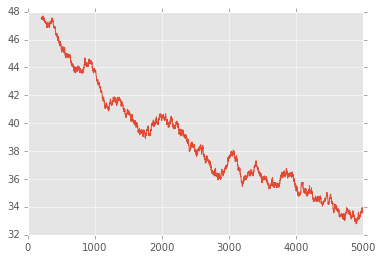

In [63]:
losses = pd.Series(losses)
losses.rolling(200).mean().plot()